In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import trim_mean, mode, skew, gaussian_kde, pearsonr, spearmanr, beta
from statsmodels.stats.weightstats import ztest as ztest
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from sklearn.model_selection import train_test_split

from scipy.stats import ttest_ind, norm, t, mannwhitneyu

from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

from scipy.stats import f_oneway
from scipy.stats import sem

### Creación del DataFrame a utilizar

In [2]:
fake_orders_test = pd.read_csv("C:\\Users\\esteb\\OneDrive\\Escritorio\\Data_Analytics_Iron_Hack\\Tercer Proyecto\\project_dataset\\python_raw_data\\fake_orders_test.csv")
fake_orders_test.head()

,order_id,activation_time_local,country_code,store_address,final_status,payment_status,products,products_total,purchase_total_price
0,33557880,2019-03-10 23:59:59.000000,AR,14200,DeliveredStatus,PAID,1,4.54,8.64
1,33512615,2019-03-10 23:58:32.000000,TR,28725,DeliveredStatus,PAID,1,3.76,3.76
2,33512451,2019-03-10 23:57:56.000000,TR,28725,DeliveredStatus,PAID,1,2.86,2.86
3,33530892,2019-03-10 23:57:33.000000,ES,19777,CanceledStatus,PAID,1,12.95,0.00
4,33557765,2019-03-10 23:57:21.000000,AR,34565,DeliveredStatus,PAID,2,2.86,6.48


Simular los grupos de control y prueba

In [3]:
# Creamos una columna de tarifa de entrega y asignamos el valor inicial a 1.9
fake_orders_test['delivery_fee'] = 1.9

# Dividimos en grupos de control (tarifa de entrega de €1.9) y prueba (tarifa de entrega de €2.1)
control_group, test_group = train_test_split(fake_orders_test, test_size=0.5, random_state=42)
test_group['delivery_fee'] = 2.1  # Ajuste de la tarifa de entrega para el grupo de prueba

# Concatenamos ambos grupos para futuras comparaciones
experiment_data = pd.concat([control_group, test_group])



#### Cálculo del tamaño de muestra y duración del experimento

In [4]:
# Definimos los parámetros del experimento
alpha = 0.05  # Nivel de significancia
power = 0.8  # Poder estadístico
baseline_conversion_rate = 0.15  # Supuesto de tasa de conversión base
mde = 0.02  # Cambio mínimo detectable en la tasa de conversión

# Cálculo del tamaño de muestra
z_alpha = norm.ppf(1 - alpha / 2)
z_beta = norm.ppf(power)
pooled_prob = (baseline_conversion_rate + (baseline_conversion_rate + mde)) / 2
sample_size = (2 * (z_alpha + z_beta)**2 * pooled_prob * (1 - pooled_prob)) / mde**2
sample_size = int(np.ceil(sample_size))

print(f"El tamaño de muestra requerido por grupo es aproximadamente: {sample_size}")



El tamaño de muestra requerido por grupo es aproximadamente: 5275


### Selección de KPIs

Los KPIs incluyen:

    Tasa de conversión (conversion_rate): Número de pedidos completados.
    Valor promedio del pedido (AOV): Promedio de la columna purchase_total_price.

###  Análisis de los resultados

In [5]:

# Calculamos la tasa de conversión y el AOV para cada grupo
control_conversion_rate = control_group['final_status'].value_counts(normalize=True).get('DeliveredStatus', 0)
test_conversion_rate = test_group['final_status'].value_counts(normalize=True).get('DeliveredStatus', 0)

control_aov = control_group['purchase_total_price'].mean()
test_aov = test_group['purchase_total_price'].mean()

print(f"Tasa de conversión - Control: {control_conversion_rate}, Prueba: {test_conversion_rate}")
print(f"AOV - Control: {control_aov}, Prueba: {test_aov}")

# Pruebas de hipótesis para comparar la conversion_rate y el AOV
t_stat, p_value = ttest_ind(control_group['purchase_total_price'], test_group['purchase_total_price'], equal_var=False)
print(f"Prueba t para AOV entre control y prueba: t={t_stat}, p={p_value}")


# Prueba de proporciones para comparar la conversion_rate
successes = [control_group['final_status'].eq('DeliveredStatus').sum(), test_group['final_status'].eq('DeliveredStatus').sum()]
nobs = [len(control_group), len(test_group)]
z_stat, p_value_conversion = proportions_ztest(successes, nobs)
print(f"Prueba Z para tasa de conversión: z={z_stat}, p={p_value_conversion}")


Tasa de conversión - Control: 0.8936092715231788, Prueba: 0.8912582781456954
AOV - Control: 10.722553973509934, Prueba: 10.684340728476823
Prueba t para AOV entre control y prueba: t=0.4355268769818101, p=0.6631815911166689
Prueba Z para tasa de conversión: z=0.9324250151314253, p=0.3511169219997061


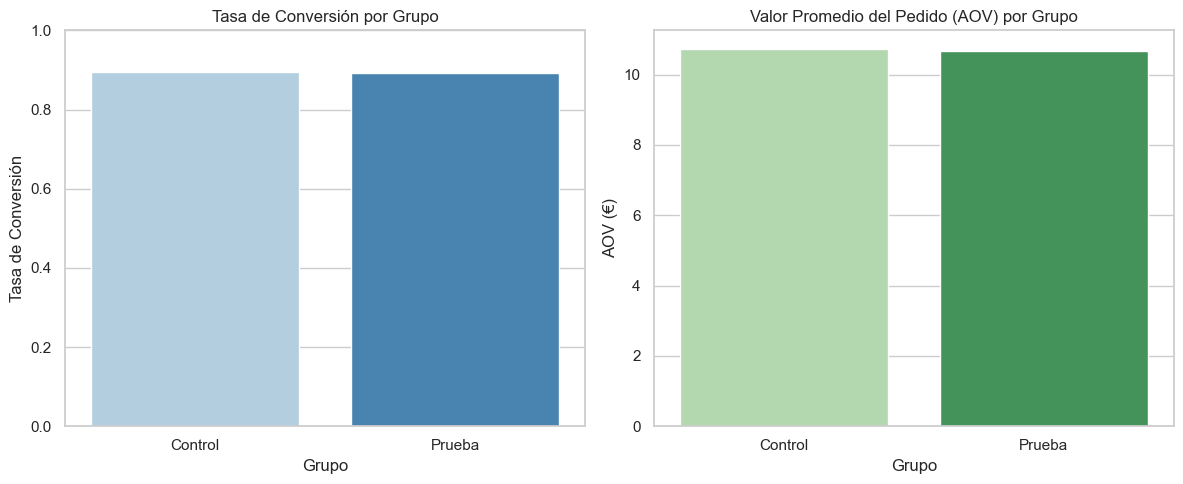

In [6]:
# Creamos un DataFrame con los resultados para facilitar la visualización
results_df = pd.DataFrame({
    'Grupo': ['Control', 'Prueba'],
    'Tasa de Conversión': [control_conversion_rate, test_conversion_rate],
    'AOV': [control_aov, test_aov]
})

# Configuramos el estilo del gráfico
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de barras para la tasa de conversión
sns.barplot(data=results_df, x='Grupo', y='Tasa de Conversión', ax=axes[0], palette="Blues")
axes[0].set_title("Tasa de Conversión por Grupo")
axes[0].set_ylim(0, 1)
axes[0].set_ylabel("Tasa de Conversión")

# Gráfico de barras para el AOV
sns.barplot(data=results_df, x='Grupo', y='AOV', ax=axes[1], palette="Greens")
axes[1].set_title("Valor Promedio del Pedido (AOV) por Grupo")
axes[1].set_ylabel("AOV (€)")


plt.tight_layout()
plt.show()

#### Análisis y recomendaciones


La tasa de conversión es prácticamente la misma en ambos grupos (89.36% en el grupo de control y 89.13% en el grupo de prueba). La prueba Z de diferencia de proporciones muestra un valor p de 0.351, que es superior al umbral de significancia comúnmente usado (0.05). Esto indica que no hay una diferencia estadísticamente significativa en la tasa de conversión entre los grupos.

El AOV también es muy similar entre ambos grupos (10.72€ para el grupo de control y 10.68€ para el grupo de prueba). La prueba t para el AOV da un valor p de 0.663, que también es muy superior al 0.05. Esto sugiere que el cambio en la tarifa de entrega no afecta significativamente el valor promedio de los pedidos.



Dado que no encontramos una diferencia significativa en la tasa de conversión ni en el valor promedio de los pedidos, se puede concluir que el aumento en la tarifa de entrega de €1.9 a €2.1 no afectó de forma negativa los principales KPIs analizados. Esto indica que el aumento es viable desde una perspectiva de impacto en los KPIs de ventas, por lo que podemos considerar implementar el aumento de tarifa, ya que no se observan impactos negativos significativos en los comportamientos de compra en el análisis actual.